# Mengimpor fungsi library

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

# Mengambil Dataset dari gdrive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Mengimpor Dataset

In [99]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 186
base_dir = os.path.join('gdrive/My Drive/Eye_diseases')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training',
    class_mode= 'categorical')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation',
    class_mode= 'categorical')

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)

Found 308 images belonging to 5 classes.
Found 75 images belonging to 5 classes.
Bentuk array dari dataset train (pelatihan) adalah: (186, 224, 224, 3) (186, 5)
Bentuk array dari dataset validation (validasi) adalah: (75, 224, 224, 3) (75, 5)


# Menyimpan label

In [100]:

print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Bulging_eyes': 0, 'Crossed_eyes': 1, 'Glaucoma': 2, 'Uveitis': 3, 'cataract': 4}


In [101]:
!cat labels.txt

Bulging_eyes
Crossed_eyes
Glaucoma
Uveitis
cataract

# Membuat model CNN

In [118]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

base_model.trainable = False
base_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 111, 111, 32) 864         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_18[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________

In [119]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

In [120]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
]
)


model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 3, 3, 32)          589856    
_________________________________________________________________
global_average_pooling2d_18  (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 165       
Total params: 22,392,805
Trainable params: 590,021
Non-trainable params: 21,802,784
_________________________________________________________________


In [121]:
history = model.fit_generator(train_generator, 
                    epochs=100, 
                    validation_data=val_generator)

Epoch 1/100
2/2 [==============================] - 3s 2s/step - loss: 3.4143 - acc: 0.3896 - val_loss: 4.7810 - val_acc: 0.2000
Epoch 2/100
2/2 [==============================] - 1s 276ms/step - loss: 4.0701 - acc: 0.2208 - val_loss: 1.4561 - val_acc: 0.5600
Epoch 3/100
2/2 [==============================] - 1s 283ms/step - loss: 1.4485 - acc: 0.5292 - val_loss: 1.7206 - val_acc: 0.4533
Epoch 4/100
2/2 [==============================] - 1s 281ms/step - loss: 1.5118 - acc: 0.4578 - val_loss: 1.2431 - val_acc: 0.5600
Epoch 5/100
2/2 [==============================] - 1s 290ms/step - loss: 1.1594 - acc: 0.5422 - val_loss: 1.4704 - val_acc: 0.3733
Epoch 6/100
2/2 [==============================] - 1s 392ms/step - loss: 1.2336 - acc: 0.3734 - val_loss: 1.3974 - val_acc: 0.4000
Epoch 7/100
2/2 [==============================] - 1s 269ms/step - loss: 1.1730 - acc: 0.4578 - val_loss: 1.3150 - val_acc: 0.5200
Epoch 8/100
2/2 [==============================] - 1s 408ms/step - loss: 1.1476 - acc:

# Menampilkan Hasil Pelatihan

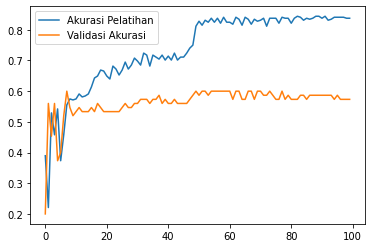

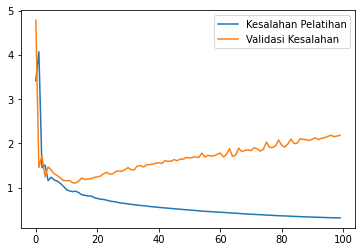

In [122]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

# Menggunakan Model

In [21]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


Labelnya adalah:  [0. 1. 0. 0. 0.]
Prediksinya adalah [2.7516766e-02 9.6585155e-01 2.7619128e-03 3.6631452e-03 2.0668398e-04]


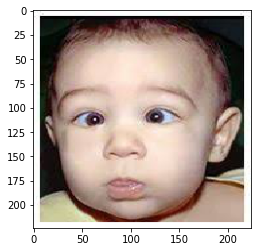

In [59]:
#Prediksi Label Validasi dengan Pelatihan
n = 56
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

plt.imshow(image_batch[n])